# 2.2 Back Transform in polar coordinates

In [84]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Berechnen der F.T. Projektion
Disclaimer: Ich verwende hier die numpy FFT, weil auch für die Reverse FFT die 

numpy funktion verwendet werden soll, sonst ist alles aus Aufgabe 1


In [85]:
# data importieren
data = np.loadtxt('Data/projection.txt', delimiter=',')
p_phi = data
Nphi = data.shape[0] 
Nxi= data.shape[1]

#Intervallle
phi_interval = np.linspace(0, np.pi, Nphi, endpoint=False)  
ksi_interval = np.linspace(-Nxi/2, Nxi/2, Nxi)
delta_ksi = ksi_interval[1] - ksi_interval[0]


kksi = np.linspace(-Nxi/2, Nxi/2, Nxi) 
F_phi = np.fft.fft(p_phi, axis=1) *delta_ksi   #FFT
print( F_phi.shape)






(180, 512)


### Unterpunkt b: range of $k_{\xi}$

Um hier den Intervall zu finden verwenden wir Formel bzw Intervall 2.42 aus dem Skript:

#### $\nu_{ny}=\frac{n}{2P}$

wobei n die Abtastpunkte (Spaltenzahl der Projektionsdata) und P die Länge des Messbereichs (Länge ds Intervall von $\xi$)

nun kann man mit k=2pi$\nu$ das gewünschte intervall berechneen, mit hilfe der Niquist Frequenz.

somit folgt 

#### $k_{max}=\frac{\pi n}{\xi_{max}-\xi_{min}}$ und $k_{min}=-\frac{\pi n}{\xi_{max}-\xi_{min}}$

### Unterpunkt c: Modified Projection



In [86]:
#Mod. Projektion ist die Rücktransformierte FFT * betrag kxi
F_k_mod1 =np.abs(kksi)[None, :] * F_phi
p_tilde = np.fft.ifft(F_k_mod1, axis=1).real




### Unterpunkt d: Schätzer und Interpolation

In [87]:
#Gitter machen
K= Nxi
x = np.linspace(ksi_interval[0], ksi_interval[-1], K)
y= np.linspace(ksi_interval[0], ksi_interval[-1], K)
X, Y = np.meshgrid(x, y, indexing="xy")

# Speicher für interpolierte Projektionen:
# Form: [phi, x, y]
p_interp = np.zeros((Nphi, K, K))

# Schleife über alle Winkel
for i in range(Nphi):
    phi = phi_interval[i]
    p_tilde_phi =p_tilde[i]

    # ksiprime berechnen
    ksi_prime= X*np.cos(phi) + Y*np.sin(phi)

    #j finden
    j= np.searchsorted(ksi_interval, ksi_prime) - 1
    j = np.clip(j, 0, Nxi - 2)

    #Lineare Interpolation, wir schauen uns benachbarte j an und bilden die Interpolation um p approximieren zu können für kisprime
    ksi_j = ksi_interval[j]
    ksi_j1 = ksi_interval[j + 1]

    owo = (ksi_prime - ksi_j)/(ksi_j1 - ksi_j)
    p_interp[i] = (1-owo)*p_tilde_phi[j] + owo*p_tilde_phi[j+1]



### Unterpunkt e:

Text(0, 0.5, "y'")

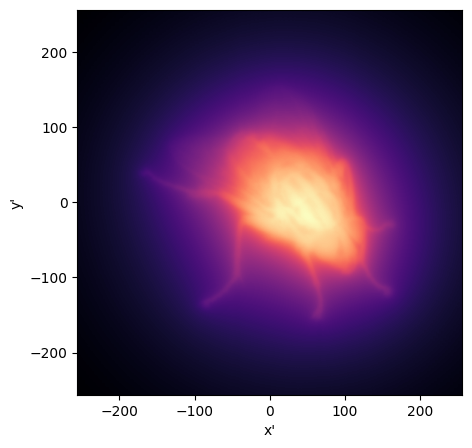

In [88]:
# Winkel-Schrittweite
delta_phi= phi_interval[1] - phi_interval[0]

# Integration über phi laut skript
f_rec = np.sum(p_interp, axis=0) * delta_phi /(2*np.pi) *np.pi/(Nphi+1)

plt.figure(figsize=(5,5))
plt.imshow(
    f_rec,
    extent=[x[0], x[-1], y[0], y[-1]],
    origin="lower",
    cmap="magma" #Fliege glüht! -> Glühwürmchen? 
)
plt.xlabel("x'")
plt.ylabel("y'")

### Unterpunkt f

In [89]:
#Optimierte kksii-Werte symmetrisch um 0 da sonst k zu groß wird teilweise
freq_opt = np.fft.fftfreq(Nxi, d=delta_ksi) 
kksi_opt  = 2.0 * np.pi * freq_opt #niqist

#Fouriertransformierte der Projektionen
F_phi_opt = np.fft.fft(p_phi, axis=1) * delta_ksi

#betrag kksi ned vergessen
F_k_mod_opt = np.abs(kksi_opt)[None, :] * F_phi_opt

#Modifizierte Projektionen wie gehabt
p_tilde_opt = np.fft.ifft(F_k_mod_opt, axis=1).real

#Backprojection
K = Nxi
x = np.linspace(ksi_interval[0], ksi_interval[-1], K)
y = np.linspace(ksi_interval[0], ksi_interval[-1], K)
X, Y = np.meshgrid(x, y, indexing="xy")

p_interp_opt = np.zeros((Nphi, K, K))

for i in range(Nphi):
    phi = phi_interval[i]
    p_tphi = p_tilde_opt[i]

    ksi_prime = X*np.cos(phi) + Y*np.sin(phi)

    j = np.searchsorted(ksi_interval, ksi_prime) - 1
    j = np.clip(j, 0, Nxi - 2)

    ksi_j  = ksi_interval[j]
    ksi_j1 = ksi_interval[j + 1]

    w = (ksi_prime - ksi_j) / (ksi_j1 - ksi_j)
    p_interp_opt[i] = (1 - w)*p_tphi[j] + w*p_tphi[j + 1]

#Integration über phi wie davor
delta_phi = phi_interval[1] - phi_interval[0]
f_rec_opt = np.sum(p_interp_opt, axis=0) * delta_phi / (2*np.pi)


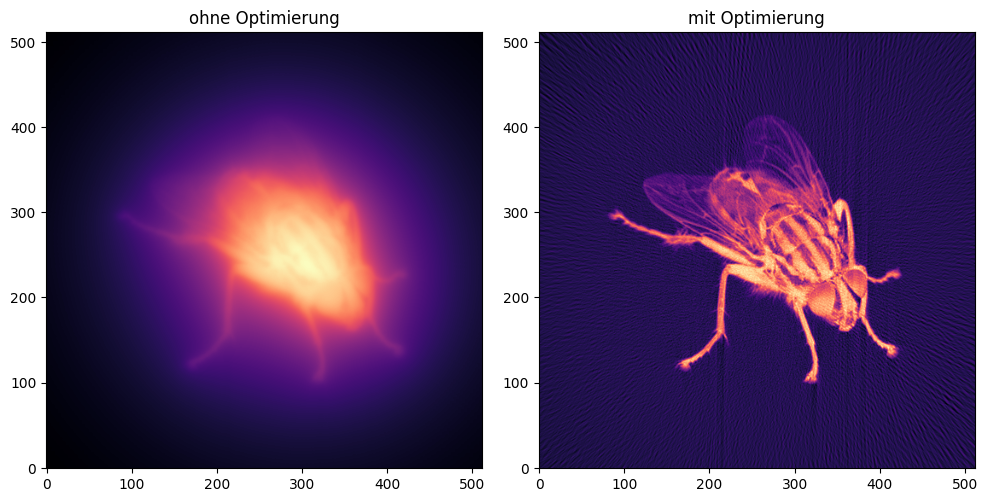

In [90]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(f_rec,     cmap="magma", origin="lower"); plt.title("ohne Optimierung")
plt.subplot(1,2,2); plt.imshow(f_rec_opt, cmap="magma", origin="lower"); plt.title("mit Optimierung")
plt.tight_layout(); plt.show()
#fancy side to side plotting 